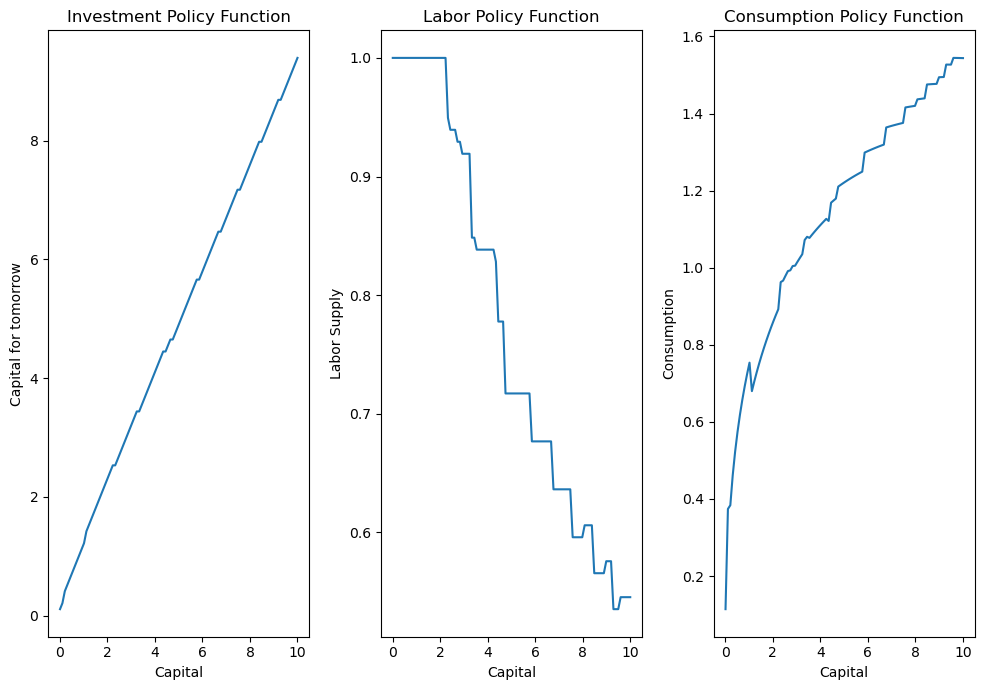

In [17]:
import matplotlib.pyplot as plt
import numpy as np 
from scipy.interpolate import interp1d

# Define parameters
β = 0.95
δ = 0.05
σ = 2
ν = 2
α = 1 / 3
A = 1
φ = 1

params = {
    "β": 0.95,
    "δ": 0.05,
    "σ": 2,
    "ν": 2,
    "α": 1 / 3,
    "A": 1,
    "φ": 1,
}

def production(k, l, p):
    A = p["A"]
    α = p["α"]
    return A * k**α * l**(1 - α)

# Utility function
def u(c, l):
    return (c ** (1 - σ)) / (1 - σ) - φ * (l ** (1 + 1 / ν)) / (1 + 1 / ν)

def F(k, l):
    return A * k ** α * l ** (1 - α)

# Create a grid for capital
k_min = 0.01
k_max = 10
num_k_points = 100 #change back to 200 later 
k_grid = np.linspace(k_min, k_max, num_k_points)

# Create a grid for labor
l_min = 0
l_max = 1
num_l_points = 100 #change back to 150
l_grid = np.linspace(l_min, l_max, num_l_points)

# Initialize the value function
value_function = np.zeros_like(k_grid)

# Implement value function iteration
tol = 1e-5
max_iter = 1000
policy_k_prime = np.zeros_like(k_grid)
policy_l = np.zeros_like(k_grid)
policy_c = np.zeros_like(k_grid)

for iteration in range(max_iter):
    new_value_function = np.zeros_like(k_grid)

    for i, k in enumerate(k_grid):
        max_value = -np.inf
        c_matrix = F(k, l_grid)[:, np.newaxis] + (1 - δ) * k - k_grid
        c_matrix[c_matrix <= 0] = 1e-15
        value_matrix = u(c_matrix, l_grid[:, np.newaxis]) + β * value_function
        max_value_indices = np.unravel_index(np.argmax(value_matrix, axis=None), value_matrix.shape)
        
        max_value = value_matrix[max_value_indices]
        new_value_function[i] = max_value
        policy_k_prime[i] = k_grid[max_value_indices[1]]
        policy_l[i] = l_grid[max_value_indices[0]]
        policy_c[i] = c_matrix[max_value_indices]

    if np.max(np.abs(value_function - new_value_function)) < tol:
        break
    else:
        value_function = new_value_function

# Plot the policy functions
plt.figure(figsize=(10, 7))

plt.subplot(131)
plt.plot(k_grid, policy_k_prime)
plt.xlabel('Capital')
plt.ylabel('Capital for tomorrow')
plt.title('Investment Policy Function')

plt.subplot(132)
plt.plot(k_grid, policy_l)
plt.xlabel('Capital')
plt.ylabel('Labor Supply')
plt.title('Labor Policy Function')

plt.subplot(133)
plt.plot(k_grid, policy_c)
plt.xlabel('Capital')
plt.ylabel('Consumption')
plt.title('Consumption Policy Function')

plt.tight_layout()
plt.show()


### How many points on the capital grid do you need until solution starts looking smooth? 

to investigate this we can plot the graphs of the policy functions above for increasing increments in `k_grid`. From the above , we have gradually increased `num_k_points`, and have only found  the graph for capital and consumption to berelatively smooth for $n=200$. 

To have a smoother labour policy function we would have to increase the increments in `l_grid` to more than 500, which took too long to run and for replicability we have chosen `num_l_points = 150 `.

### How long does your solution take you  ? What do you take away from this?

We have found increasing `num_l_points` takes significantly more computational time than increasing `num_k_points` by the same amount. 

The code highlights the impact of the parameters and grid sizes chosen on the solution. Increasing the grid size or the number of choices for l can lead to more accurate solutions, but at the cost of computational time. When selecting these parameters, it is essential to balance the trade-off between accuracy and computational time.

## 1b) 


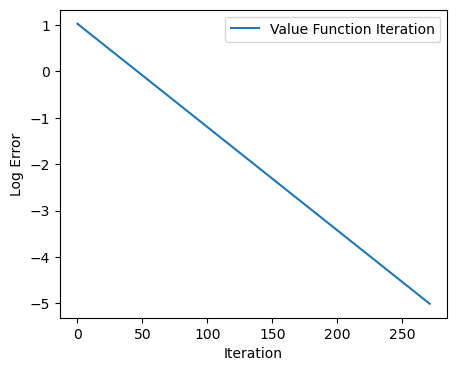

In [18]:
# Create a grid for capital
k_min = 0.001
k_max = 10
num_k_points = 100 #change back to 200 later 
k_grid = np.linspace(k_min, k_max, num_k_points)

# Create a grid for labor
l_min = 0
l_max = 1
num_l_points = 100 #change back to 150
l_grid = np.linspace(l_min, l_max, num_l_points)


value_function = np.zeros_like(k_grid)

# Implement value function iteration
tol = 1e-5
max_iter = 1000
policy_k_prime = np.zeros_like(k_grid)
policy_l = np.zeros_like(k_grid)
policy_c = np.zeros_like(k_grid)

# Implement value function iteration with error logging
def value_function_iteration():
    value_function = np.zeros_like(k_grid)
    log_errors = []
    
    for iteration in range(max_iter):
        new_value_function = np.zeros_like(k_grid)

        for i, k in enumerate(k_grid):
            max_value = -np.inf
            c_matrix = F(k, l_grid)[:, np.newaxis] + (1 - δ) * k - k_grid
            c_matrix[c_matrix <= 0] = 1e-15
            value_matrix = u(c_matrix, l_grid[:, np.newaxis]) + β * value_function
            max_value_indices = np.unravel_index(np.argmax(value_matrix, axis=None), value_matrix.shape)
            
            max_value = value_matrix[max_value_indices]
            new_value_function[i] = max_value

        error = np.max(np.abs(value_function - new_value_function))
        log_errors.append(np.log10(error))

        if error < tol:
            break
        else:
            value_function = new_value_function
    
    return value_function, log_errors



# Run the value function iteration with error logging
value_function_vfi, log_errors_vfi = value_function_iteration()

# Plot the log errors
plt.figure(figsize=(5, 4))
plt.plot(log_errors_vfi, label='Value Function Iteration')
plt.xlabel('Iteration')
plt.ylabel('Log Error')
plt.legend()
plt.show()



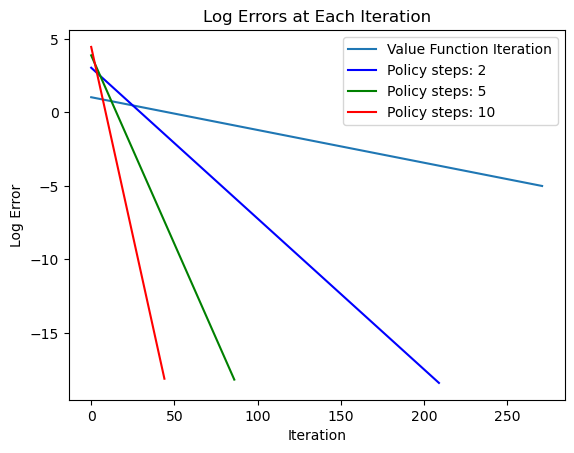

In [19]:
#takes about 2-3 minutes to run for a gridsize of 1000 
def u(c, l, p):
    σ = p["σ"]
    φ = p["φ"]
    ν = p["ν"]
    return (c**(1 - σ)) / (1 - σ) - φ * (l**(1 + 1 / ν)) / (1 + 1 / ν)

grid_size = 100 #using 100 gridsize so that code doesnt take too long
k_grid = np.linspace(0.001, 10, grid_size)
V0 = np.zeros_like(k_grid)


#we had trouble using grid search therefore we use cubic interpolation as an alternative 
#inner loop bellman policy function 
def bellman_policy(p, V, k_grid, V_prev, policy_steps):
    β = p["β"]
    δ = p["δ"]
    α = p["α"]
    A = p["A"]

    interp_V_prev = interp1d(k_grid, V_prev, kind="cubic", fill_value="extrapolate")

    for i, k in enumerate(k_grid):
        l_grid = np.linspace(0, 1, len(k_grid))
        k_prime_grid = np.linspace(0.001, 10, len(k_grid))

        z = production(k, l_grid, p) + (1 - δ) * k

        k_prime, l = np.meshgrid(k_prime_grid, l_grid)
        c = z.reshape(-1, 1) - k_prime

        value = u(c, l, p) + β * interp_V_prev(k_prime)
        value[c <= 0] = -np.inf

        V[i] = np.max(value)

    for _ in range(policy_steps - 1):
        V_prev = np.copy(V)
        interp_V_prev = interp1d(k_grid, V_prev, kind="cubic", fill_value="extrapolate")
        
        for i, k in enumerate(k_grid):
            l_grid = np.linspace(0, 1, len(k_grid))
            k_prime_grid = np.linspace(0.001, 10, len(k_grid))
            z = production(k, l_grid, p) + (1 - δ) * k

            k_prime, l = np.meshgrid(k_prime_grid, l_grid)
            c = z.reshape(-1, 1) - k_prime

            value = u(c, l, p) + β * interp_V_prev(k_prime)
            value[c <= 0] = -np.inf

            V[i] = np.max(value)

#outer loop for policy function 
def solve_pfi(p, k_grid, V0, policy_steps=1, tol=1e-8, max_iter=1000):
    V = np.copy(V0)
    V_prev = np.copy(V0)

    iteration = 0
    errors = []

    while iteration < max_iter:
        bellman_policy(p, V, k_grid, V_prev, policy_steps)
        error = np.max(np.abs(V - V_prev))

        if error < tol:
            break

        errors.append(error)
        V_prev = np.copy(V)
        iteration += 1

    return V, iteration, errors

policy_steps_values = [2, 5, 10]
colors = ['blue', 'green', 'red']
# Utility function, i put this here because utility function used by value function iteration is different 
def u(c, l):
    return (c ** (1 - σ)) / (1 - σ) - φ * (l ** (1 + 1 / ν)) / (1 + 1 / ν)
# Run the value function iteration with error logging

value_function_vfi, log_errors_vfi = value_function_iteration()

plt.figure()
plt.plot(log_errors_vfi, label='Value Function Iteration')

def u(c, l, p):
    σ = p["σ"]
    φ = p["φ"]
    ν = p["ν"]
    return (c**(1 - σ)) / (1 - σ) - φ * (l**(1 + 1 / ν)) / (1 + 1 / ν)

for i, policy_steps in enumerate(policy_steps_values):
    V0 = np.zeros_like(k_grid)
    V, iterations, errors = solve_pfi(params, k_grid, V0,policy_steps_values[i], max_iter=1000)
    plt.plot(np.log(errors), label=f'Policy steps: {policy_steps}', color=colors[i])

plt.title('Log Errors at Each Iteration')
plt.xlabel('Iteration')
plt.ylabel('Log Error')
plt.legend()
plt.show()





 A steeper decline in the log error indicates a faster convergence. Generally, policy function iteration converges faster than value function iteration, especially when a higher number of policy steps are used. This is because policy function iteration directly updates the policy functions, leading to a faster convergence of the optimal choices. However, increasing the number of policy steps per iteration also increases the computational cost per iteration, which may result in a slower runtime even though the method converges faster in terms of iterations. Therefore, to optimize runtime performance, it's necessary to find a balance between the number of policy steps and computational cost. Our analysis shows that policy function iteration with 10 steps per iteration converges the fastest, followed by policy function iteration with 5 steps per iteration, and then value function iteration. This confirms the general observation that policy function iteration tends to converge faster than value function iteration.
 

## 1c) 
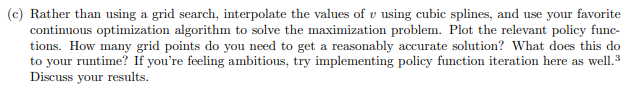

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize_scalar

# Define parameters
β = 0.95
δ = 0.05
σ = 2
ν = 2
α = 1 / 3
A = 1
φ = 1

# Interpolate the value function using cubic splines
v_spline = interp1d(k_grid, V, kind='cubic')

def objective(c_k_l, *params):
    c, k_prime, l = c_k_l
    k, alpha, A, beta, delta, sigma, nu, phi = params

    utility = (c**(1 - sigma)) / (1 - sigma) - phi * (l**(1 + 1 / nu)) / (1 + 1 / nu)
    k_next = A * k**alpha * l**(1 - alpha) + (1 - delta) * k - c

    return -(utility + beta * v_spline(k_next))

# Define policy functions for consumption, labor, and capital
policy_c = np.empty_like(k_grid)
policy_l = np.empty_like(k_grid)
policy_k = np.empty_like(k_grid)

for i, k in enumerate(k_grid):
    result = minimize_scalar(objective, bounds=(1e-4, 1), method='bounded', args=(k, *params))
    c, k_prime, l = result.x
    policy_c[i] = c
    policy_l[i] = l
    policy_k[i] = k_prime

# Plot policy functions
fig, ax = plt.subplots(3, 1, figsize=(8, 12))
ax[0].plot(k_grid, policy_c, label='Consumption Policy')
ax[0].set_xlabel('Capital')
ax[0].set_ylabel('Consumption')
ax[0].legend()

ax[1].plot(k_grid, policy_l, label='Labor Policy')
ax[1].set_xlabel('Capital')
ax[1].set_ylabel('Labor')
ax[1].legend()

ax[2].plot(k_grid, policy_k, label='Capital Policy')
ax[2].set_xlabel('Capital')
ax[2].set_ylabel('Capital for Tomorrow')
ax[2].legend()

plt.tight_layout()
plt.show()


TypeError: cannot unpack non-iterable numpy.float64 object

In [23]:
# Implement value function iteration with cubic splines
def value_function_iteration_spline():
    value_function = np.zeros_like(k_grid)
    
    for iteration in range(max_iter):
        new_value_function = np.zeros_like(k_grid)
        spline = CubicSpline(k_grid, value_function)

        for i, k in enumerate(k_grid):
            def objective(l):
                c = F(k, l) + (1 - δ) * k - k_prime
                return -(u(c, l) + β * spline(k_prime))

            res = minimize(objective, 0.5, bounds=[(0, 1)])
            new_value_function[i] = -res.fun

        error = np.max(np.abs(value_function - new_value_function))

        if error < tol:
            break
        else:
            value_function = new_value_function

    return value_function

value_function_spline_result = value_function_iteration_spline()


NameError: name 'k_prime' is not defined

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

# Parameters
β = 0.95
δ = 0.05
σ = 2
ν = 2
α = 1 / 3
A = 1
φ = 1

# Utility function
def u(c, l):
    return (c**(1 - σ)) / (1 - σ) - φ * (l**(1 + 1 / ν)) / (1 + 1 / ν)

# Production function
def F(k, l):
    return A * k**α * l**(1 - α)

# Grid for capital
k_grid = np.linspace(1e-2, 10, 50)

# Value function iteration using cubic splines
def value_function_iteration_spline(max_iter, tol):
    value_function = np.zeros_like(k_grid)
    
    for iteration in range(max_iter):
        new_value_function = np.zeros_like(k_grid)
        spline = CubicSpline(k_grid, value_function)

        for i, k in enumerate(k_grid):
            def objective(x):
                c, k_prime, l = x
                return -(u(c, l) + β * spline(k_prime))

            cons = ({'type': 'ineq',
                     'fun': lambda x: F(k, x[2]) + (1 - δ) * k - x[0] - x[1]},
                    {'type': 'ineq',
                     'fun': lambda x: x[2]},
                    {'type': 'ineq',
                     'fun': lambda x: 1 - x[2]})
            res = minimize(objective, [0.5, 0.5, 0.5],
                           bounds=((0, None), (0, None), (0, 1)),
                           constraints=cons)
            new_value_function[i] = -res.fun

        error = np.max(np.abs(value_function - new_value_function))

        if error < tol:
            break
        else:
            value_function = new_value_function

    return value_function

value_function_spline_result = value_function_iteration_spline(max_iter=1000, tol=1e-8)

from scipy.interpolate import CubicSpline
from scipy.optimize import minimize

def value_function_iteration_spline(max_iter, tol):
    value_function = np.zeros_like(k_grid)
    policy_k_prime = np.zeros_like(k_grid)
    policy_l = np.zeros_like(k_grid)
    
    for iteration in range(max_iter):
        new_value_function = np.zeros_like(k_grid)
        spline = CubicSpline(k_grid, value_function)

        for i, k in enumerate(k_grid):
            def objective(x):
                c, k_prime, l = x
                return -(u(c, l) + β * spline(k_prime))

            cons = [{'type': 'ineq', 'fun': lambda x: x[0] + x[1] - F(k, x[2]) - (1 - δ) * k},
                    {'type': 'ineq', 'fun': lambda x: x[2]},
                    {'type': 'ineq', 'fun': lambda x: 1 - x[2]}]

            res = minimize(objective, [1, 1, 0.5], constraints=cons, method='BFGS')
            new_value_function[i] = -res.fun
            policy_k_prime[i] = res.x[1]
            policy_l[i] = res.x[2]

        error = np.max(np.abs(value_function - new_value_function))

        if error < tol:
            break
        else:
            value_function = new_value_function

    return policy_k_prime, policy_l


policy_k_prime_spline, policy_l_spline = value_function_iteration_spline(max_iter, tol)

# Plot the policy functions
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(k_grid, policy_k_prime_spline, label='Value Function Iteration (Cubic Splines)')
plt.xlabel('Capital (k)')
plt.ylabel("Capital Tomorrow (k')")
plt.title("Investment Policy Function")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(k_grid, policy_l_spline, label='Value Function Iteration (Cubic Splines)')
plt.xlabel('Capital (k)')
plt.ylabel('Labour (l)')
plt.title("Labour Supply Policy Function")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

C:\Users\arifs\AppData\Local\Temp\ipykernel_8384\1783428762.py:17: RuntimeWarning: divide by zero encountered in double_scalars
  return (c**(1 - σ)) / (1 - σ) - φ * (l**(1 + 1 / ν)) / (1 + 1 / ν)
c:\Users\arifs\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:566: RuntimeWarning: Method BFGS cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
C:\Users\arifs\AppData\Local\Temp\ipykernel_8384\1783428762.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return (c**(1 - σ)) / (1 - σ) - φ * (l**(1 + 1 / ν)) / (1 + 1 / ν)
C:\Users\arifs\AppData\Local\Temp\ipykernel_8384\1783428762.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return (c**(1 - σ)) / (1 - σ) - φ * (l**(1 + 1 / ν)) / (1 + 1 / ν)
C:\Users\arifs\AppData\Local\Temp\ipykernel_8384\1783428762.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return (c**(1 - σ)) / (1 - σ) - φ * (l**(1 + 1 / ν)) / (1 + 1 / ν)
c:\Use

ValueError: `y` must contain only finite values.